In [1]:
import numpy as np
from datetime import datetime
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
from datetime import datetime
plt.rcParams['figure.figsize'] = [15, 7.5]
plt.rcParams.update({'font.size': 16,'legend.fontsize':16})
import seaborn as sns
import sys
import os
from config import get_from_config, save_to_config
import fur.path_assistant as path_assistant
from fur.waveform_reader import read_waveform
from fur.finding_period import get_period
from fur.fluctuations import get_fluctiation_and_noise_var, get_average_signal
shift_03_09_2020 = path_assistant.PathAssistant('shift_03_09_2020',      
    ignore_files=["RefCurve_2020-03-10_0_111937_test.Wfm.bin"])
waveforms_dir = shift_03_09_2020.get_waveforms_dir()
results_dir = shift_03_09_2020.get_results_dir()
additional_data_dir = shift_03_09_2020.get_additional_data_dir()
bpm_files_df = shift_03_09_2020.get_bpm_files_df()
acnet_data_df = shift_03_09_2020.get_acnet_data_df("all_acnet_data_for_directly_connected_case_03_09_2020.csv")
t1 = datetime(2020, 3, 9, 19, 8, 0)
t2 = datetime(2020, 3, 9, 19, 42, 0)

In [2]:
fluctuation_waveforms_df = shift_03_09_2020.get_fluctuation_waveforms_df()
bpm_files_df = shift_03_09_2020.get_bpm_files_df()

In [3]:
bpm_files_df = bpm_files_df[(bpm_files_df["file_datetime"] > t1) \
& (bpm_files_df["file_datetime"]<t2)].reset_index()

In [4]:
fluctuation_waveforms_df = fluctuation_waveforms_df[(fluctuation_waveforms_df["file_datetime"] > t1) \
& (fluctuation_waveforms_df["file_datetime"]<t2)].reset_index()

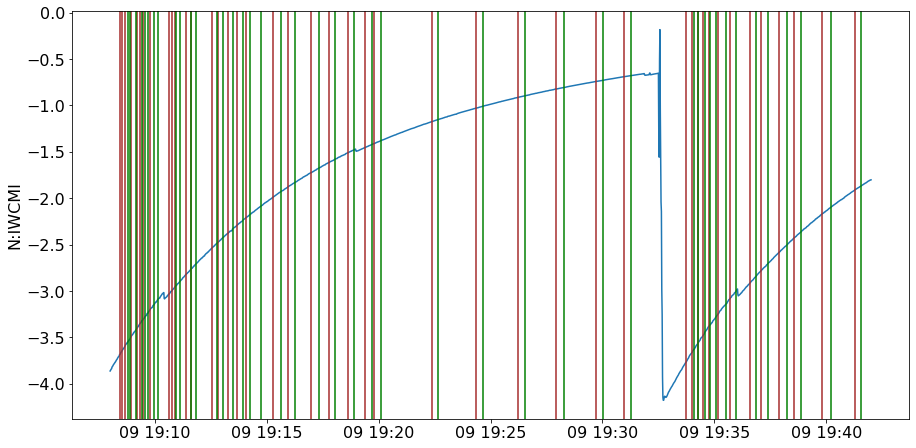

In [5]:
ax = sns.lineplot(x=acnet_data_df.index, y=acnet_data_df["N:IWCMI"])
for t in fluctuation_waveforms_df["file_datetime"]:
    plt.axvline(t, color="brown")
for t in bpm_files_df["file_datetime"]:
    plt.axvline(t, color="green")
plt.show()

In [6]:
fluctuation_waveforms_df["rounded_bpm_file_datetime"] = \
    bpm_files_df["file_datetime"].apply(lambda t: t.round(freq='S'))

In [7]:
fluctuation_waveforms_df["N:IWCMI"] = fluctuation_waveforms_df["rounded_bpm_file_datetime"] \
    .apply(lambda t: acnet_data_df.loc[t, "N:IWCMI"])

In [8]:
res_df = shift_03_09_2020.get_fluctuations_df("res_df_directly_connected_FLAT_03_09_2020.csv")

In [9]:
current = -get_from_config("IWCMI_to_WCM_ABSOLUTE")*fluctuation_waveforms_df["N:IWCMI"].values
amplitude = res_df["ch2_amplitude"].values

In [10]:
reg = linear_model.LinearRegression(fit_intercept=False)
x = current
y = amplitude
reg.fit(x.reshape((len(x), 1)), y)
a = reg.coef_[0]
a

0.3516107535210208

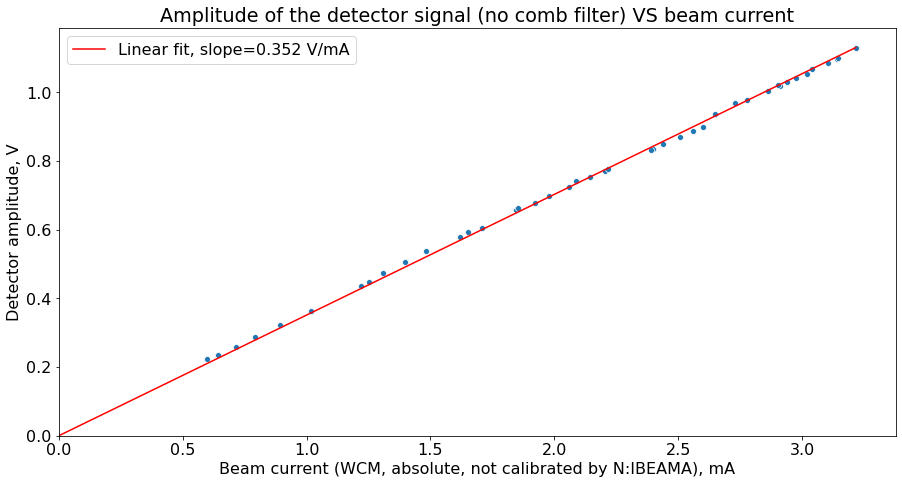

In [11]:
ax = sns.scatterplot(current, amplitude)
ax2 = sns.lineplot(x=[0, max(current)],y=[0, a*max(current)], color='red',
    label="Linear fit, slope={:.3f} V/mA".format(a))
ax.set_xlabel("Beam current (WCM, absolute, not calibrated by N:IBEAMA), mA")
ax.set_ylabel("Detector amplitude, V")
ax.set_ylim(0, ax.get_ylim()[1])
ax.set_xlim(0, ax.get_xlim()[1])
ax.set_title("Amplitude of the detector signal (no comb filter) VS beam current")
plt.show()

The main conclusion: it's impirically proven that the relation between current and singal amplitude is linear. Now it's enough to find the theoretical prediction for the slope only for one value of beam current (signal amplitude). If it agrees with the experiment, it's great, no need to check it for other values of current (I had a concern that the varying bunch length could also change the proportionality coefficient between current and amplitude, but in the plot above it looks like the coefficient is roughly constant).

In [12]:
photons_per_electron = 0.01221971387651638

Assuming all light that reaches the lens, is then collected by the detector's sensitive area. Also, assuming ideal RC filter and ideal photodiode (infinitely fast):

In [13]:
slope_theory = 1/(get_from_config("Cf"))*photons_per_electron*get_from_config("IOTA_revolution_period")/1000
slope_theory

0.8146475917473924

In [14]:
I_to_S = get_from_config("Beam_current_to_Sum_channel_ampl_V/mA")
S_to_Ne = get_from_config("sum_channel_to_photoelectrons")
integrator_to_photoelectrons = 1/a*I_to_S*S_to_Ne
save_to_config("integrator_amp_to_photoelectrons", integrator_to_photoelectrons )

In [15]:
fluctuation_waveforms_df["bpm_file_path"] = bpm_files_df["file_path"]

In [16]:
fluctuation_waveforms_df.head()

,index,file_name,file_path,file_datetime,rounded_bpm_file_datetime,N:IWCMI,bpm_file_path
0,11,RefCurve_2020-03-09_11_190827.Wfm.bin,/mnt/c/Users/lobac_000/OneDrive - Fermi Nation...,2020-03-09 19:08:27,2020-03-09 19:08:47,-3.547789,/mnt/c/Users/lobac_000/OneDrive - Fermi Nation...
1,12,RefCurve_2020-03-09_12_190831.Wfm.bin,/mnt/c/Users/lobac_000/OneDrive - Fermi Nation...,2020-03-09 19:08:31,2020-03-09 19:08:54,-3.507342,/mnt/c/Users/lobac_000/OneDrive - Fermi Nation...
2,13,RefCurve_2020-03-09_13_190839.Wfm.bin,/mnt/c/Users/lobac_000/OneDrive - Fermi Nation...,2020-03-09 19:08:39,2020-03-09 19:09:10,-3.413848,/mnt/c/Users/lobac_000/OneDrive - Fermi Nation...
3,14,RefCurve_2020-03-09_14_190857.Wfm.bin,/mnt/c/Users/lobac_000/OneDrive - Fermi Nation...,2020-03-09 19:08:57,2020-03-09 19:09:25,-3.319769,/mnt/c/Users/lobac_000/OneDrive - Fermi Nation...
4,15,RefCurve_2020-03-09_15_190911.Wfm.bin,/mnt/c/Users/lobac_000/OneDrive - Fermi Nation...,2020-03-09 19:09:11,2020-03-09 19:09:32,-3.288017,/mnt/c/Users/lobac_000/OneDrive - Fermi Nation...


In [17]:
idx = 1
detector_wf_file_path = fluctuation_waveforms_df.loc[idx, "file_path"]
wcm_wf_file_path = fluctuation_waveforms_df.loc[idx, "bpm_file_path"]
bpm_wf_0 = -pd.read_csv(wcm_wf_file_path, index_col=0)["reconstructed_signal"]
av_lev = np.mean(bpm_wf_0[400:1000])
bpm_wf_0 = bpm_wf_0-av_lev
data_len = len(bpm_wf_0)
ch = read_waveform(detector_wf_file_path, one_channel=True)
period = get_period(ch)
detector_wf = get_average_signal(ch, period, n_bins=data_len)

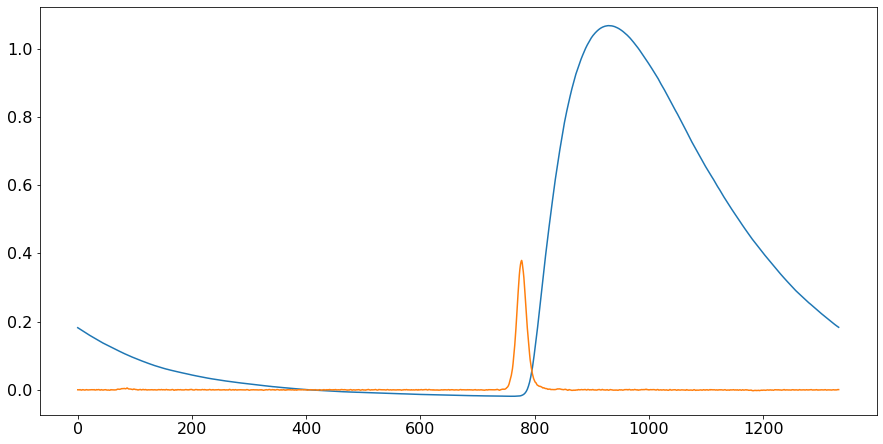

In [18]:
plt.plot(detector_wf)
bpm_wf = np.roll(bpm_wf_0,-275)
plt.plot(bpm_wf)
plt.show()

In [19]:
max(detector_wf)

1.0670154094696045

In [20]:
dt = period*get_from_config("dt")/data_len
dt

0.09999843378337268

In [21]:
freqs = np.fft.rfftfreq(data_len, dt)

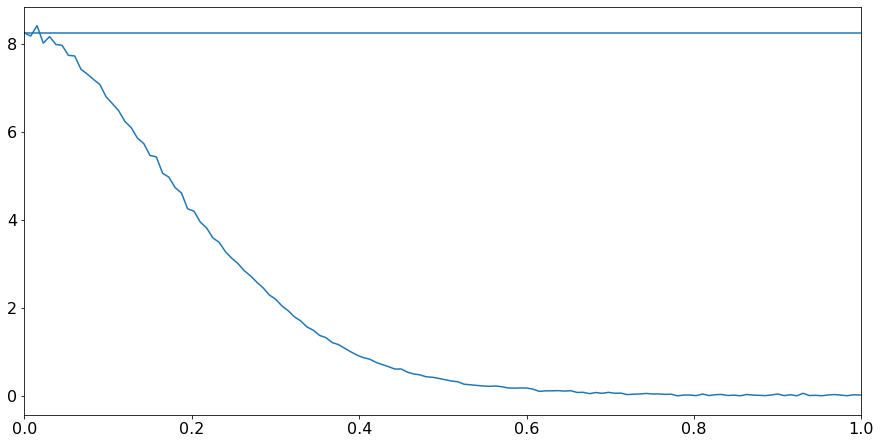

In [22]:
bpm_fft = np.fft.rfft(bpm_wf)
plt.plot(freqs, np.absolute(bpm_fft))
plt.xlim(0,1.0)
plt.axhline(np.absolute(bpm_fft[0]))
plt.show()

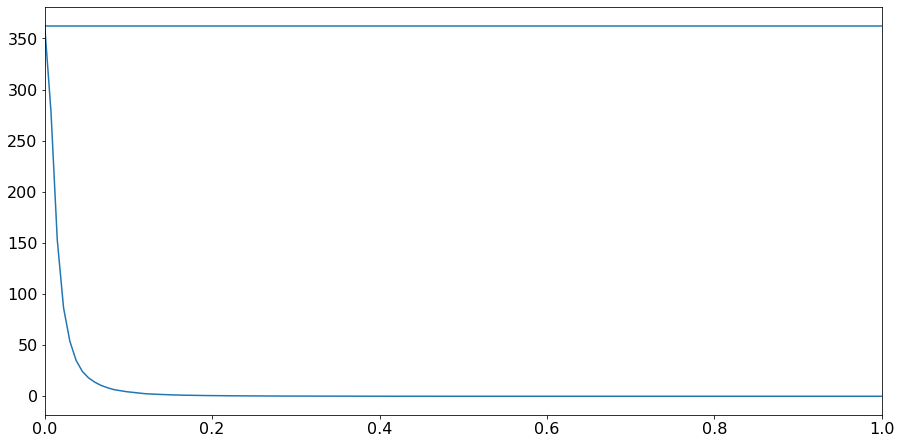

In [23]:
detector_fft = np.fft.rfft(detector_wf)
plt.plot(freqs, np.absolute(detector_fft))
plt.axhline(np.absolute(detector_fft[0]))
plt.xlim(0,1.0)
plt.show()

In [24]:
measured_transmission = detector_fft/bpm_fft

In [25]:
Rf = get_from_config("Rf")  # Ohm
Cf = get_from_config("Cf")  # F
tau = Rf*Cf*1e9
predicted_transmission = 1/Cf/(1/tau+1j*2*np.pi*freqs)
f_transmission = predicted_transmission[0]/measured_transmission[0]*measured_transmission
predicted_bd_transmission = measured_transmission[0]/predicted_transmission[0]*predicted_transmission

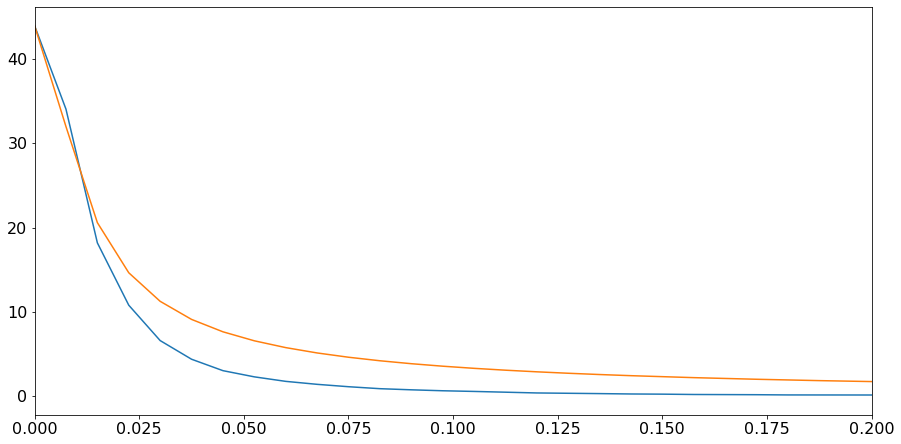

In [26]:
plt.plot(freqs, np.absolute(measured_transmission))
plt.plot(freqs, np.absolute(predicted_bd_transmission))
#plt.yscale('log')
#plt.xscale('log')
plt.xlim(0,0.2)
plt.show()

In [27]:
predicted_Vd = np.fft.irfft(bpm_fft*predicted_bd_transmission, data_len)
photodiode_current = 1e9*np.fft.irfft(detector_fft/predicted_transmission, data_len)

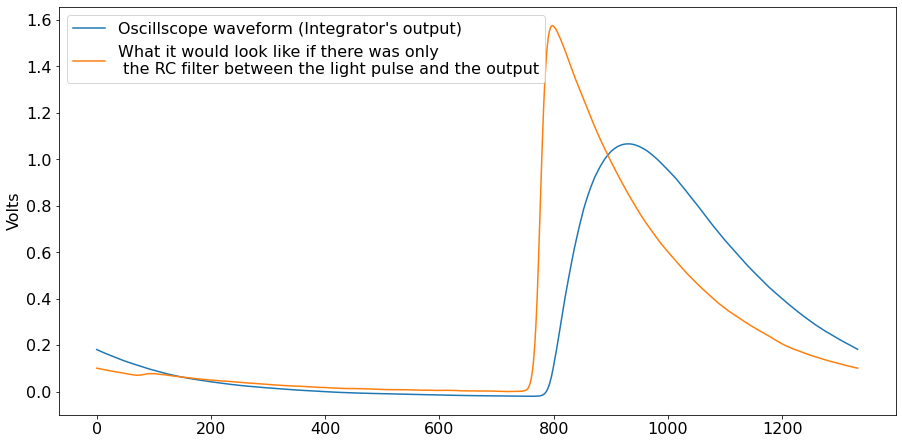

In [28]:
plt.plot(detector_wf, label="Oscillscope waveform (Integrator's output)")
plt.plot(predicted_Vd, label="What it would look like if there was only\n the RC filter between the light pulse and the output")
plt.ylabel("Volts")
plt.legend()
plt.show()

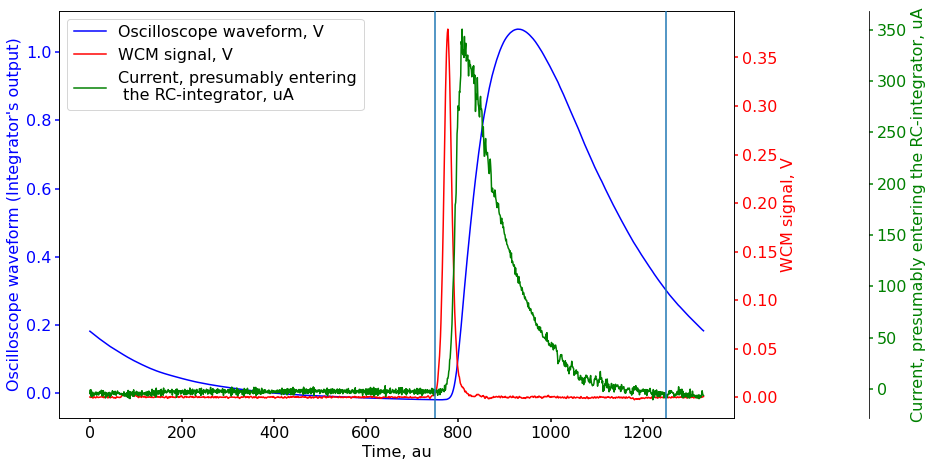

In [29]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)
fig, host = plt.subplots()
fig.subplots_adjust(right=0.75)
par1 = host.twinx()
par2 = host.twinx()
par2.spines["right"].set_position(("axes", 1.2))
make_patch_spines_invisible(par2)
par2.spines["right"].set_visible(True)

p1, = host.plot(detector_wf, "b-", label="Oscilloscope waveform, V")
p2, = par1.plot(bpm_wf, "r-", label="WCM signal, V")
p3, = par2.plot(1e6*photodiode_current, "g-", label="Current, presumably entering\n the RC-integrator, uA")

host.set_xlabel("Time, au")
host.set_ylabel("Oscilloscope waveform (Integrator's output)")
par1.set_ylabel("WCM signal, V")
par2.set_ylabel("Current, presumably entering the RC-integrator, uA")

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())
par2.yaxis.label.set_color(p3.get_color())

tkw = dict(size=4, width=1.5)
host.tick_params(axis='y', colors=p1.get_color(), **tkw)
par1.tick_params(axis='y', colors=p2.get_color(), **tkw)
par2.tick_params(axis='y', colors=p3.get_color(), **tkw)
host.tick_params(axis='x', **tkw)
par2.axvline(750)
par2.axvline(750+500)

lines = [p1, p2, p3]

host.legend(lines, [l.get_label() for l in lines])

plt.show()

In [30]:
prl_images = get_from_config("PRL_images")
per = get_from_config("IOTA_revolution_period")

/home/ilobach/fur/env/lib/python3.6/site-packages/ipykernel_launcher.py:46: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
/home/ilobach/fur/env/lib/python3.6/site-packages/ipykernel_launcher.py:49: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.


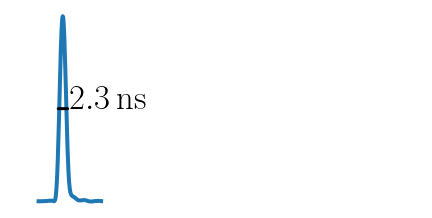

/home/ilobach/fur/env/lib/python3.6/site-packages/ipykernel_launcher.py:46: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
/home/ilobach/fur/env/lib/python3.6/site-packages/ipykernel_launcher.py:49: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.


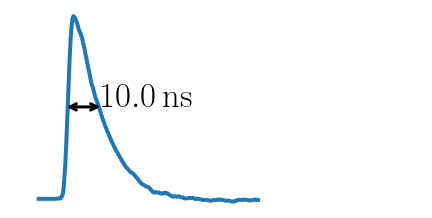

/home/ilobach/fur/env/lib/python3.6/site-packages/ipykernel_launcher.py:46: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
/home/ilobach/fur/env/lib/python3.6/site-packages/ipykernel_launcher.py:49: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.


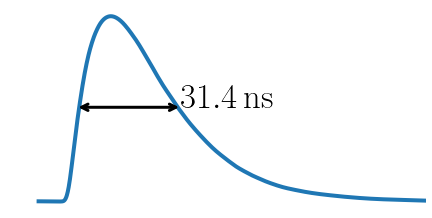

In [62]:
plt.rcParams["text.usetex"] =True
plt.rc('text.latex', preamble=r'\usepackage{siunitx}')
plt.rcParams['figure.figsize'] = [scale*25, scale*7.5]
scale=0.5
plt.rcParams['figure.figsize'] = [scale*15, scale*7.5]
from scipy.signal import savgol_filter
dt = get_from_config("dt")
roll = -600
savgol_filter_params = dict(
    window_length=51,
    polyorder=5)
wfs = [
    bpm_wf,
    photodiode_current,
    detector_wf
      ]
wfs_roll = [np.roll(wf, roll) for wf in wfs]
wfs_filtered = [savgol_filter(wf,**savgol_filter_params) for wf in wfs_roll]
left_pos = []
right_pos = []
d = 10
for wf in wfs_filtered:
    halfmax = max(wf)/2
    for i,y in enumerate(wf):
        if i>0:
            if (y>halfmax) and (wf[i-1]<=halfmax):
                left_pos.append(i-d)
            if (y<halfmax) and (wf[i-1]>=halfmax):
                right_pos.append(i+d)
names = ["wcm_wf.png", "photodiode_wf.png", "integrator_wf.png"]
xlims = [
    [100,300],
    [100,800],
    [100,1333]
]
for i,wf in enumerate(wfs_filtered):
    halfmax = max(wf)/2
    left, right = left_pos[i], right_pos[i]
    plt.plot(range(*xlims[i]),wf[xlims[i][0]:xlims[i][1]], linewidth=scale*8)
    plt.xlim(0,len(wf))
    arrowstyle = '-' if i==0 else '<->'
    plt.annotate(s="", xy=(left, halfmax),
                 xytext=(right, halfmax),
                 arrowprops=dict(
                     arrowstyle=arrowstyle,
                     linewidth=scale*6))
    dt0 = per*1e9/len(wf)
    plt.annotate(s=r"\SI{"+f"{(right-left-2*d)*dt0:.1f}" + r"}{ns}",xy=(right, halfmax),
                fontsize=scale*70)
    plt.axis('off')
    plt.savefig(os.path.join(prl_images,
                             "integrator_and_comb_filter"
                             ,names[i]),
            dpi=300, bbox_inches='tight')
    plt.show()

/home/ilobach/fur/env/lib/python3.6/site-packages/ipykernel_launcher.py:46: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
/home/ilobach/fur/env/lib/python3.6/site-packages/ipykernel_launcher.py:49: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
/home/ilobach/fur/env/lib/python3.6/site-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facevolor" which is no longer supported as of 3.3 and will become an error two minor releases later


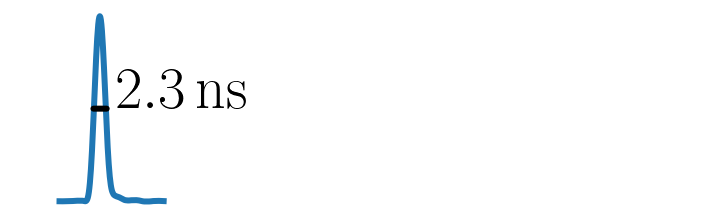

/home/ilobach/fur/env/lib/python3.6/site-packages/ipykernel_launcher.py:46: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
/home/ilobach/fur/env/lib/python3.6/site-packages/ipykernel_launcher.py:49: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
/home/ilobach/fur/env/lib/python3.6/site-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facevolor" which is no longer supported as of 3.3 and will become an error two minor releases later


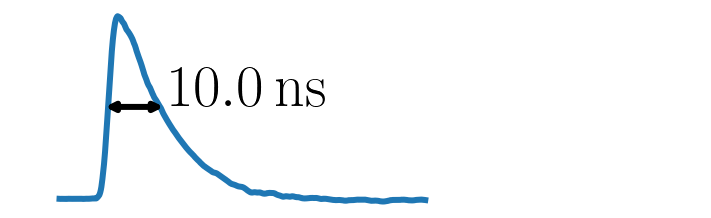

/home/ilobach/fur/env/lib/python3.6/site-packages/ipykernel_launcher.py:46: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
/home/ilobach/fur/env/lib/python3.6/site-packages/ipykernel_launcher.py:49: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
/home/ilobach/fur/env/lib/python3.6/site-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facevolor" which is no longer supported as of 3.3 and will become an error two minor releases later


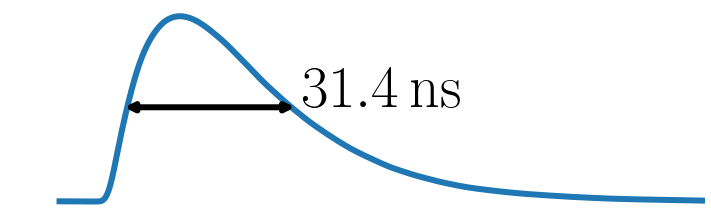

In [68]:
scale=0.5
plt.rcParams["text.usetex"] =True
plt.rc('text.latex', preamble=r'\usepackage{siunitx}')
plt.rcParams['figure.figsize'] = [scale*25, scale*7.5]
from scipy.signal import savgol_filter
dt = get_from_config("dt")
roll = -600
savgol_filter_params = dict(
    window_length=51,
    polyorder=5)
wfs = [
    bpm_wf,
    photodiode_current,
    detector_wf
      ]
wfs_roll = [np.roll(wf, roll) for wf in wfs]
wfs_filtered = [savgol_filter(wf,**savgol_filter_params) for wf in wfs_roll]
left_pos = []
right_pos = []
d = 10
for wf in wfs_filtered:
    halfmax = max(wf)/2
    for i,y in enumerate(wf):
        if i>0:
            if (y>halfmax) and (wf[i-1]<=halfmax):
                left_pos.append(i-d)
            if (y<halfmax) and (wf[i-1]>=halfmax):
                right_pos.append(i+d)
names = ["wcm_wf_no_FWHM.png", "photodiode_wf_no_FWHM.png", "integrator_wf_no_FWHM.png"]
xlims = [
    [100,300],
    [100,800],
    [100,1333]
]
for i,wf in enumerate(wfs_filtered):
    halfmax = max(wf)/2
    left, right = left_pos[i], right_pos[i]
    plt.plot(range(*xlims[i]),wf[xlims[i][0]:xlims[i][1]], linewidth=scale*12)
    plt.xlim(0,len(wf))
    arrowstyle = '-' if i==0 else '<->'
    ddd = 5 if i==0 else 0
    plt.annotate(s="", xy=(left+ddd, halfmax),
                 xytext=(right-ddd, halfmax),
                 arrowprops=dict(
                     arrowstyle=arrowstyle,
                     linewidth=scale*12))
    dt0 = per*1e9/len(wf)
    plt.annotate(s=r"\SI{"+f"{(right-left-2*d)*dt0:.1f}" + r"}{ns}",xy=(right+10, halfmax),
                fontsize=scale*120)
    plt.axis('off')
    plt.savefig(os.path.join(prl_images,
                             "integrator_and_comb_filter"
                             ,names[i]),
            dpi=300, bbox_inches='tight', facevolor='white')
    plt.show()

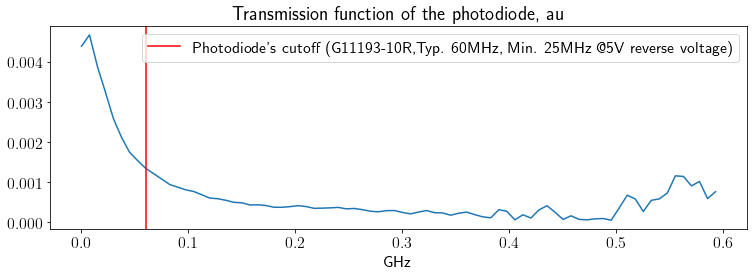

In [33]:
photodiode_transmission = np.fft.rfft(photodiode_current)/np.fft.rfft(bpm_wf)
i_max = 80
plt.plot(freqs[:i_max], np.absolute(photodiode_transmission)[:i_max])
plt.axvline(0.06, color='red', label="Photodiode's cutoff (G11193-10R,Typ. 60MHz, Min. 25MHz @5V reverse voltage)")
plt.legend()
plt.title("Transmission function of the photodiode, au")
plt.xlabel("GHz")
plt.show()

# Comparing the detector waveforms with the waveform collected with the other Photodiode (G11193-02R), which was much faster:

In [34]:
faster_detector_ch = -pd.read_csv(additional_data_dir.fi("with_light.Wfm.csv"), header=None).iloc[:, 0].values

In [35]:
faster_detector_period = get_period(faster_detector_ch)

In [36]:
per_idx = int(np.round(faster_detector_period))

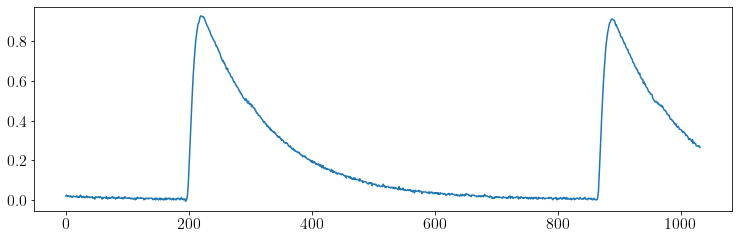

In [37]:
plt.plot(faster_detector_ch)
plt.show()

In [38]:
xp = np.arange(per_idx)
x = np.linspace(0,per_idx, data_len)
faster_detector_wf_0 = np.interp(x, xp, faster_detector_ch[:per_idx])

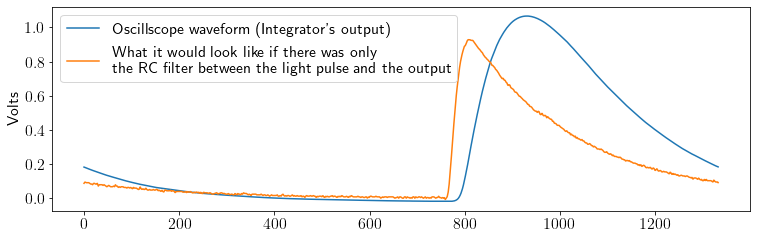

In [39]:
faster_detector_wf = np.roll(faster_detector_wf_0, 370)
plt.plot(detector_wf, label="Oscillscope waveform (Integrator's output)")
plt.plot(faster_detector_wf, label="What it would look like if there was only\n the RC filter between the light pulse and the output")
plt.ylabel("Volts")
plt.legend()
plt.show()

In [40]:
faster_photodiode_current = 1e9*np.fft.irfft(np.fft.rfft(faster_detector_wf)/predicted_transmission, data_len)

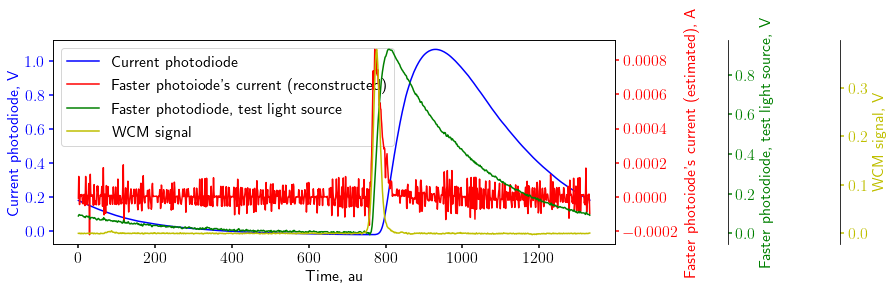

In [41]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)
fig, host = plt.subplots()
fig.subplots_adjust(right=0.75)
par1 = host.twinx()
par2 = host.twinx()
par3 = host.twinx()
par2.spines["right"].set_position(("axes", 1.2))
make_patch_spines_invisible(par2)
par2.spines["right"].set_visible(True)
par3.spines["right"].set_position(("axes", 1.4))
make_patch_spines_invisible(par3)
par3.spines["right"].set_visible(True)

p1, = host.plot(detector_wf, "b-", label="Current photodiode")
p2, = par1.plot(faster_photodiode_current, "r-", label="Faster photoiode's current (reconstructed)")
p3, = par2.plot(faster_detector_wf, "g-", label="Faster photodiode, test light source")
p4, = par3.plot(bpm_wf, "y-", label="WCM signal")

host.set_xlabel("Time, au")
host.set_ylabel("Current photodiode, V")
par1.set_ylabel("Faster photoiode's current (estimated), A")
par2.set_ylabel("Faster photodiode, test light source, V")
par3.set_ylabel("WCM signal, V")


host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())
par2.yaxis.label.set_color(p3.get_color())
par3.yaxis.label.set_color(p4.get_color())


tkw = dict(size=4, width=1.5)
host.tick_params(axis='y', colors=p1.get_color(), **tkw)
par1.tick_params(axis='y', colors=p2.get_color(), **tkw)
par2.tick_params(axis='y', colors=p3.get_color(), **tkw)
par3.tick_params(axis='y', colors=p4.get_color(), **tkw)
host.tick_params(axis='x', **tkw)

lines = [p1, p2, p3, p4]

host.legend(lines, [l.get_label() for l in lines])

plt.show()

The reconstructed current from the faster photodiode has much smaller time scale than the reconstructed current for the slower (current) photodiode. In fact, the time scale is on the order of the WCM signal. 

Let's assume that the RC integrator part works just like in theory (this assumes that the opamp has infinite bandwidth). And on top of that there is the photodiode with cutoff at 60MHz. That's what distorts our signal.

The plan: reconstruct the input of the RC integrator assuming theoretical ideal transmission of the RC integrator. And then, integrate that current to obtain the number of produced photoelectrons.

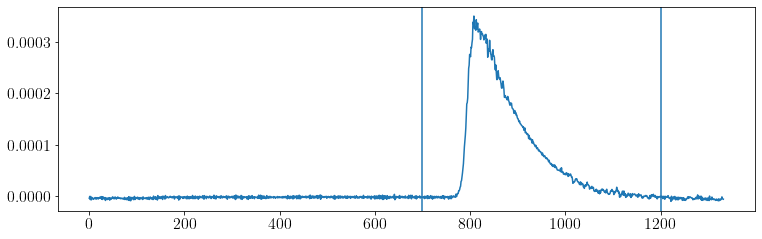

In [42]:
plt.plot(photodiode_current)
start = 700
end = 1200
plt.axvline(start)
plt.axvline(end)
plt.show()

In [43]:
n_photoelectrons = 1/get_from_config("e")*dt*1e-9*sum(photodiode_current[start:end])
n_photoelectrons

9688934.418110073

In [44]:
n_electron_in_bunch = -0.001*fluctuation_waveforms_df.loc[idx, "N:IWCMI"]*get_from_config("IWCMI_to_WCM_ABSOLUTE")*get_from_config("IOTA_revolution_period")/get_from_config("e")
n_electron_in_bunch

2581879353.3388534

In [45]:
n_photoelectrons/n_electron_in_bunch

0.0037526673760260977

In [46]:
fluctuation_waveforms_df["n_electrons_in_bunch"] = -0.001*fluctuation_waveforms_df.loc[:, "N:IWCMI"]*get_from_config("IWCMI_to_WCM_ABSOLUTE")*get_from_config("IOTA_revolution_period")/get_from_config("e")

In [47]:
indiv_fluct_df = pd.read_csv(results_dir.fi("indiv_fluct_df_directly_connected_FLAT_03_09_2020.csv"), index_col=0)

In [48]:
indiv_fluct_df["wf_datetime"] = indiv_fluct_df["file_path"].apply(lambda p: shift_03_09_2020.get_datetime(os.path.basename(p)))

In [49]:
indiv_fluct_df = indiv_fluct_df.sort_values("wf_datetime").reset_index()

In [50]:
fir, ax = plt.subplots()
x = fluctuation_waveforms_df["n_electrons_in_bunch"].values
y = indiv_fluct_df["mean"].values
reg = linear_model.LinearRegression(fit_intercept=False)
reg.fit(x.reshape((-1, 1)), y)
photons_per_electron = reg.coef_[0]
ax.plot(x, y, 'o')
ax.set_xlabel("Number of electrons in the bunch")
ax.set_ylabel("Number of photoelectrons")
ax.set_xlim(0, ax.get_xlim()[1])
ax.set_ylim(0, ax.get_ylim()[1])
x_fit = np.array([0,ax.get_xlim()[1]])
ax.plot(x_fit, photons_per_electron*x_fit)
s = "photons_per_electron = {:.6f}".format(photons_per_electron)
ax.text(0.05, 0.95, s,
        verticalalignment='bottom', horizontalalignment='left',
        transform=ax.transAxes, fontsize=16)
plt.show()

RuntimeError: latex was not able to process the following string:
b'photons_per_electron = 0.008799'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.21 (TeX Live 2020) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode

(/home/ilobach/.cache/matplotlib/tex.cache/fca9cae00c4dc080034488c8e225e409.tex
LaTeX2e <2020-02-02> patch level 5
L3 programming layer <2020-03-06>
(/usr/local/texlive/2020/texmf-dist/tex/latex/base/article.cls
Document Class: article 2019/12/20 v1.4l Standard LaTeX document class
(/usr/local/texlive/2020/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2020/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2020/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/local/texlive/2020/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/local/texlive/2020/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/local/texlive/2020/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2020/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2020/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/local/texlive/2020/texmf-dist/tex/generic/iftex/iftex.sty))

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (/usr/local/texlive/2020/texmf-dist/tex/latex/siunitx/siunitx.sty
(/usr/local/texlive/2020/texmf-dist/tex/latex/l3kernel/expl3.sty
(/usr/local/texlive/2020/texmf-dist/tex/latex/l3backend/l3backend-dvips.def))
(/usr/local/texlive/2020/texmf-dist/tex/latex/l3packages/xparse/xparse.sty)
(/usr/local/texlive/2020/texmf-dist/tex/latex/amsmath/amstext.sty
(/usr/local/texlive/2020/texmf-dist/tex/latex/amsmath/amsgen.sty))
(/usr/local/texlive/2020/texmf-dist/tex/latex/tools/array.sty)
(/usr/local/texlive/2020/texmf-dist/tex/latex/l3packages/l3keys2e/l3keys2e.sty)
(/usr/local/texlive/2020/texmf-dist/tex/latex/translator/translator.sty))
(/usr/local/texlive/2020/texmf-dist/tex/latex/base/textcomp.sty)
(./fca9cae00c4dc080034488c8e225e409.aux)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips

(/usr/local/texlive/2020/texmf-dist/tex/latex/translator/translator-basic-dicti
onary-English.dict)
(/usr/local/texlive/2020/texmf-dist/tex/latex/siunitx/siunitx-abbreviations.cfg
)
! Missing $ inserted.
<inserted text> 
                $
l.19 {\sffamily photons_
                        per_electron = 0.008799}
No pages of output.
Transcript written on fca9cae00c4dc080034488c8e225e409.log.




<Figure size 900x270 with 1 Axes>

In [51]:
from config import save_to_config

In [52]:
save_to_config("Measured_photons_per_electron", photons_per_electron)